<a href="https://colab.research.google.com/github/aghakishiyeva/Interpretable-ML/blob/main/AIPI590_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
from pygam import GAM, s, f
import statsmodels.api as sm

In [16]:
# Load the data
url = 'https://raw.githubusercontent.com/aghakishiyeva/Interpretable-ML/main/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# Exploratory Data Analysis

In [17]:
# Data overview
print("Dataset Overview:")
print(df.shape)
df.head()

Dataset Overview:
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
# Checking for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [19]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [20]:
# Data preprocessing
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

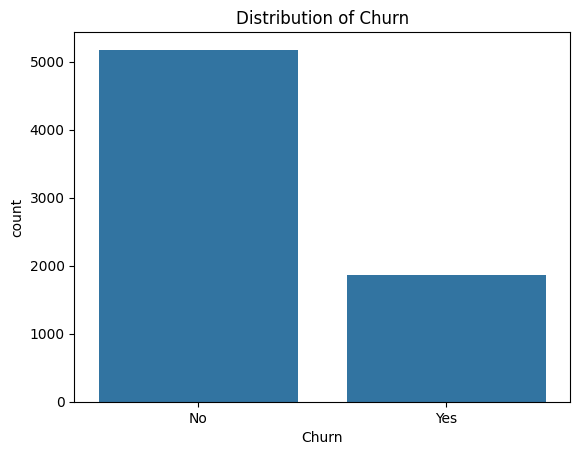

In [21]:
# Distribution of the target variable
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Churn')
plt.show()

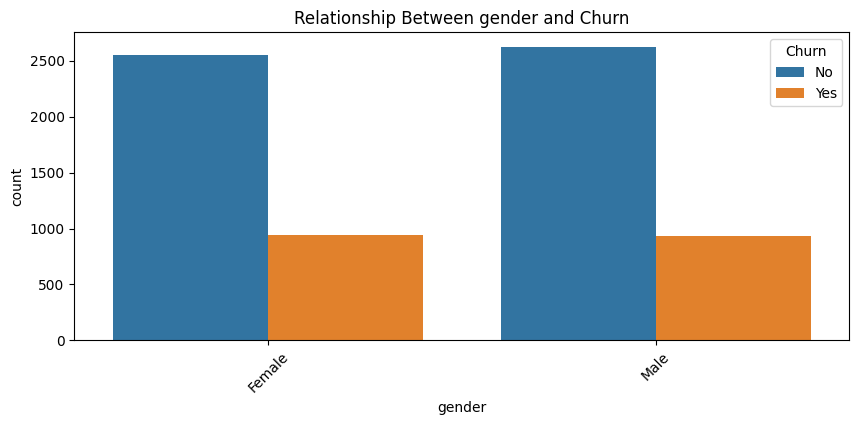

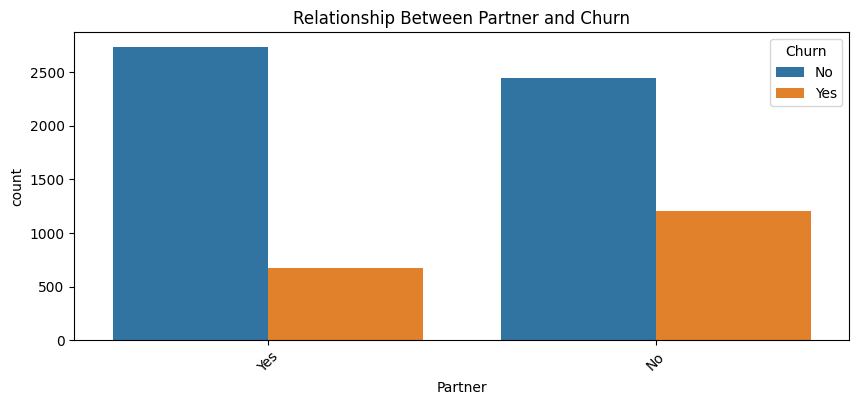

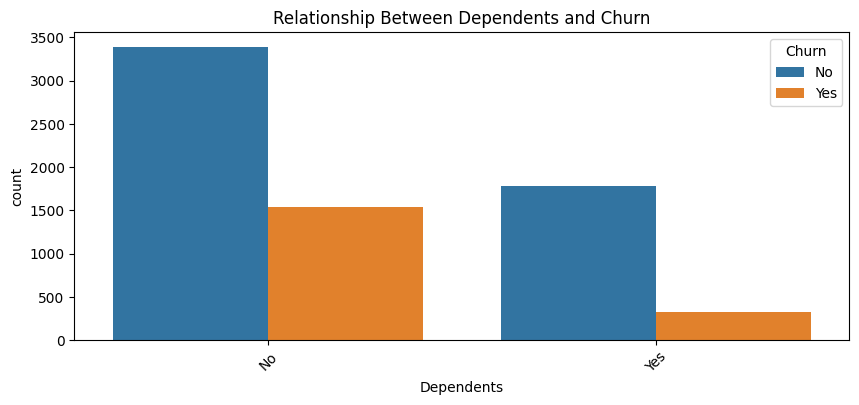

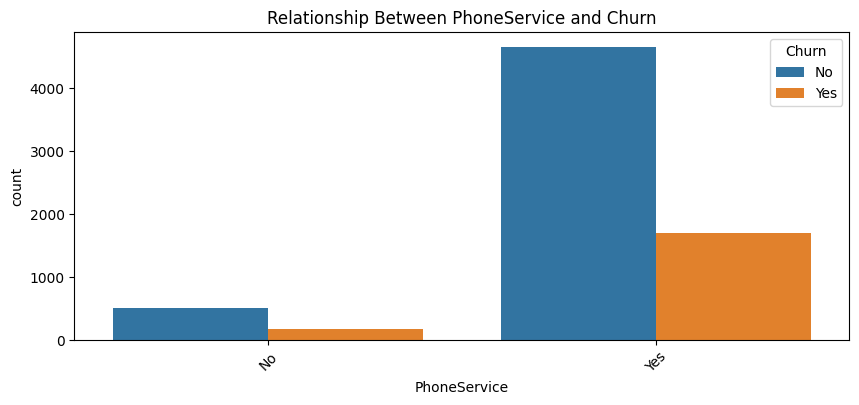

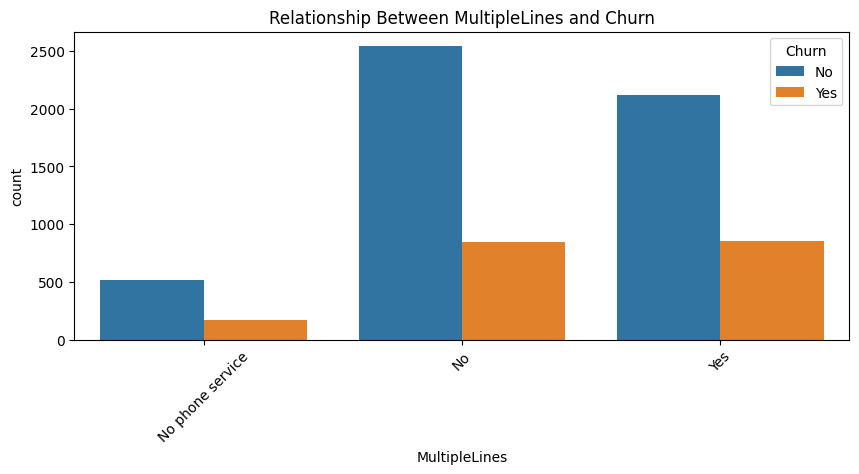

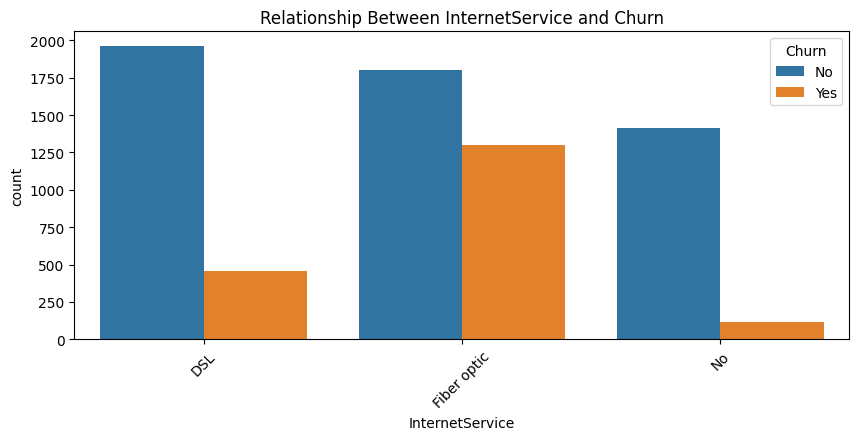

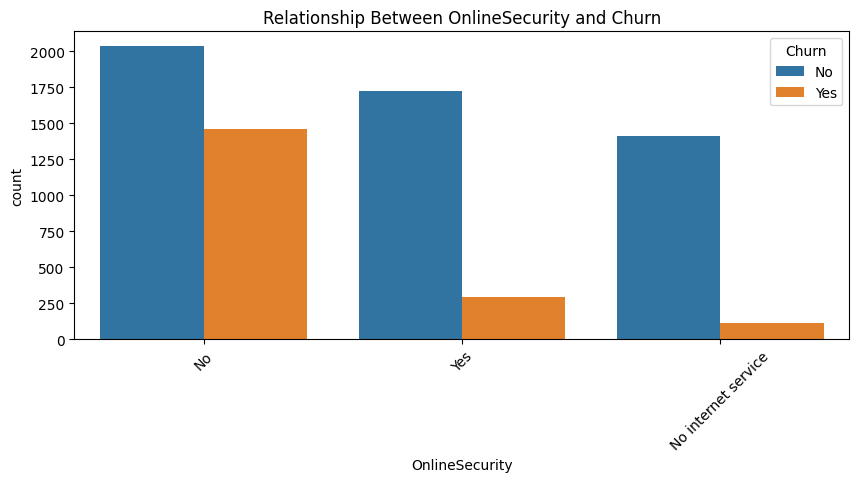

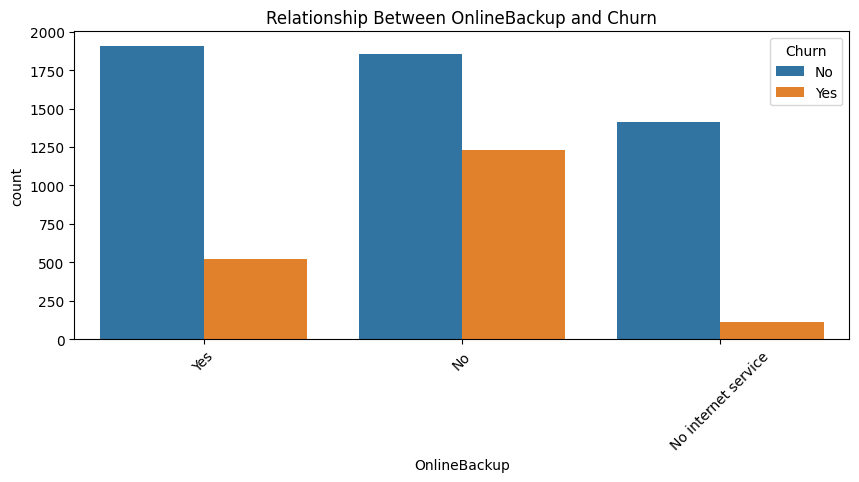

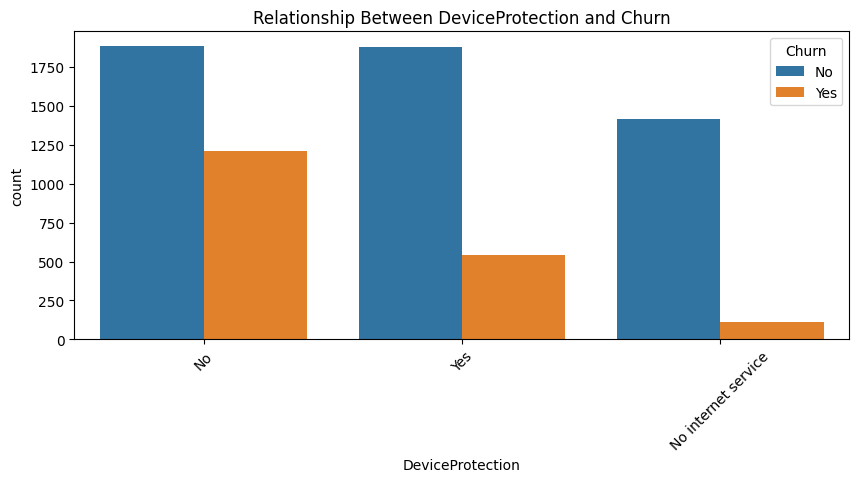

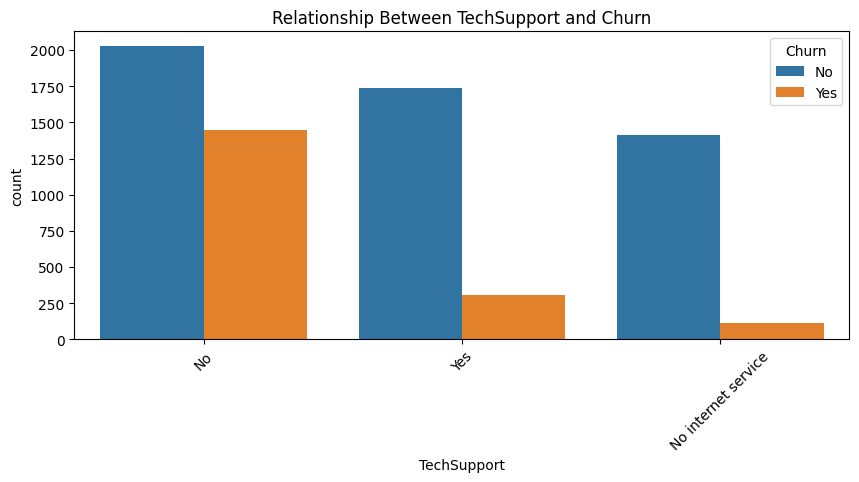

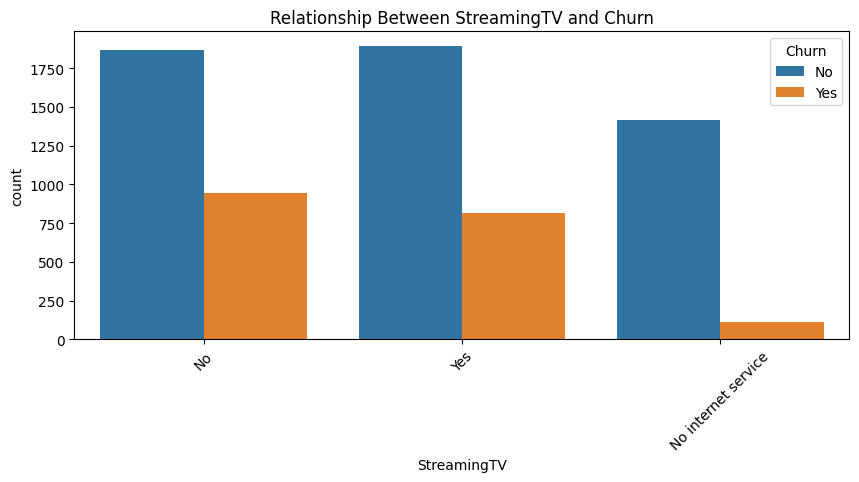

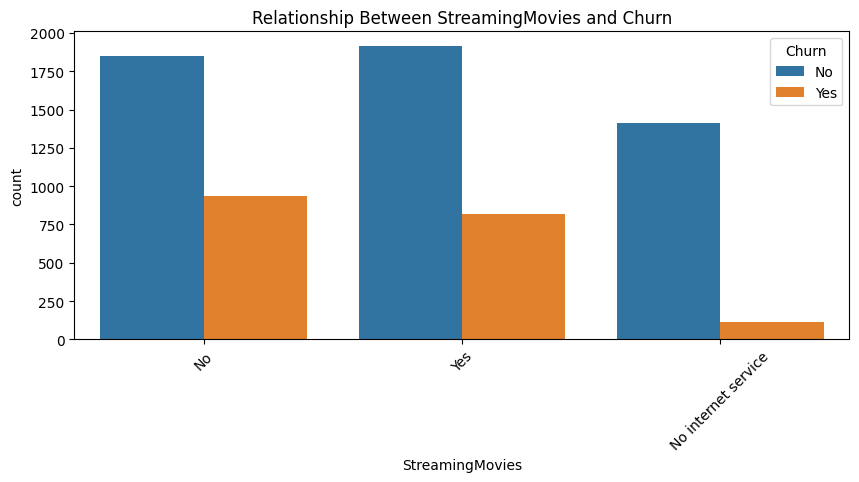

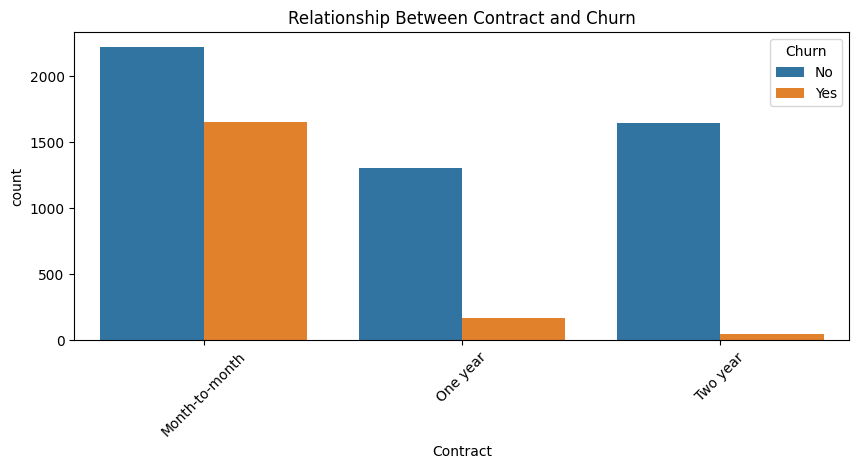

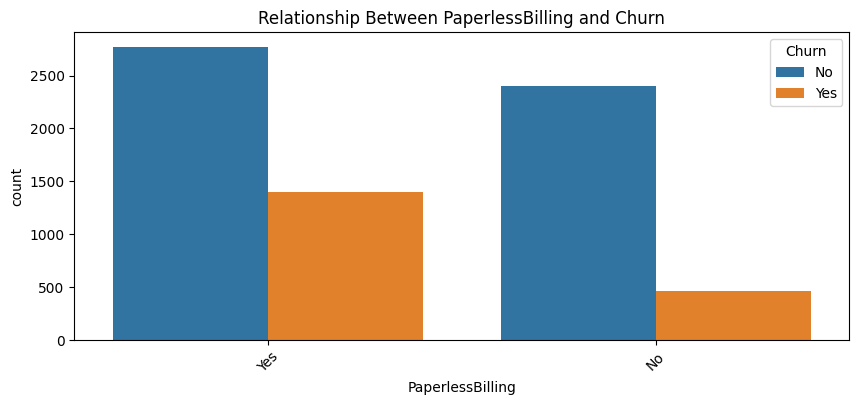

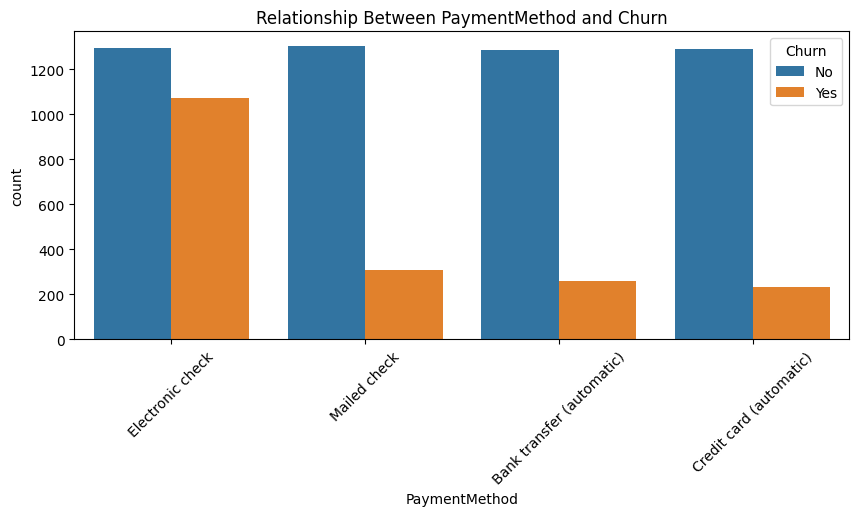

In [23]:
# The relationship between categorical features and churn
categorical_features = df.select_dtypes(include=['object']).columns.drop(['customerID', 'Churn'])

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=feature, hue='Churn')
    plt.title(f'Relationship Between {feature} and Churn')
    plt.xticks(rotation=45)
    plt.show()

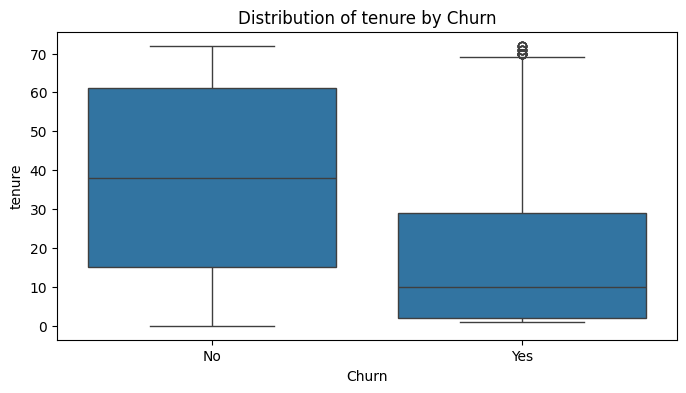

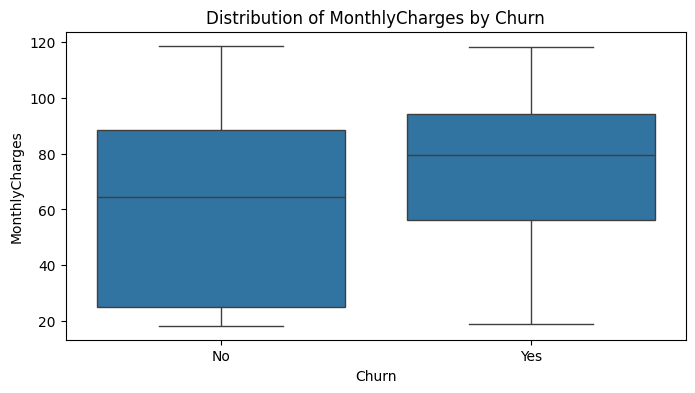

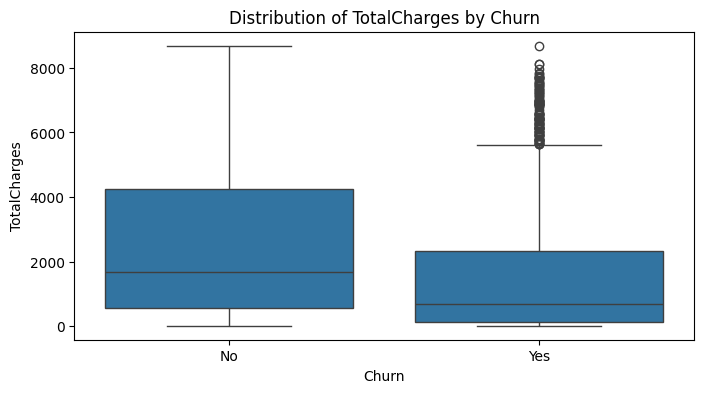

In [24]:
# The relationship between numerical features and churn
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='Churn', y=feature)
    plt.title(f'Distribution of {feature} by Churn')
    plt.show()

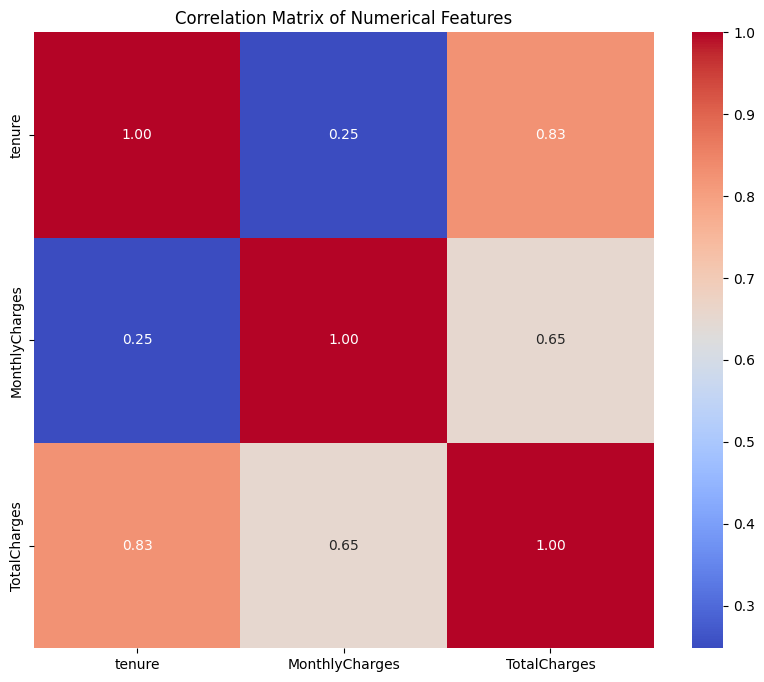

In [25]:
# Correlation matrix for numerical features
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Checking Model Assumptions

## Linear Regression

## Logistic Regression

## GAM